In [23]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xlrd

In [24]:
df_excel = pd.read_excel('/Users/Jia/Downloads/data_skripsi/tb/data_tb.xlsx')

In [25]:
# Mengonversi kolom 'time' ke tipe data datetime
df_excel['time'] = pd.to_datetime(df_excel['time'])

# Menambahkan kolom 'month'
df_excel['month'] = df_excel['time'].dt.month

# Menambahkan kolom 'year'
df_excel['year'] = df_excel['time'].dt.year

In [26]:
# Load shapefile into a GeoDataFrame
gdf_shapefile = gpd.read_file(r"/Users/Jia/Downloads/data_skripsi/kota_DKIJakarta/Kota_DKIJakarta.shp")

In [27]:
# Convert DataFrame to GeoDataFrame
geometry = gpd.points_from_xy(df_excel['longitude'], df_excel['latitude'])
gdf_excel = gpd.GeoDataFrame(df_excel, geometry=geometry, crs="EPSG:4326")

<Axes: >

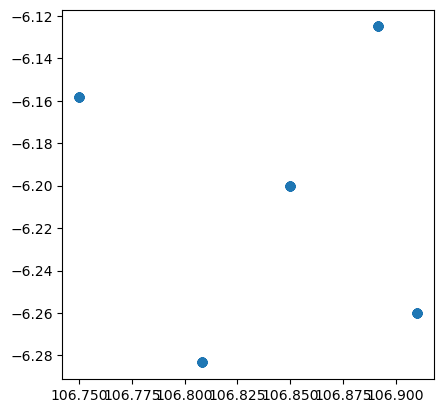

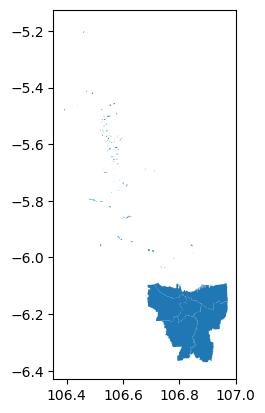

In [28]:
gdf_excel.plot()
gdf_shapefile.plot()

In [29]:
# spatial join
result = gdf_excel.merge(gdf_shapefile, on = 'KABKOT')
result['geometry'] = result['geometry_y']
result = gpd.GeoDataFrame(result)
result_pop = result[['longitude', 'latitude', 'tb', 'month', 'year', 'KABKOT', 'geometry', 'time']]

In [30]:
# Identify rows in gdf_excel that don't have a match in the result
non_matching_rows = gdf_excel[~gdf_excel.index.isin(result.index)]
print(non_matching_rows)

Empty GeoDataFrame
Columns: [KABKOT, month, year, tb, longitude, latitude, time, geometry]
Index: []


Axes(0.220549,0.11;0.583903x0.77)
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   longitude  180 non-null    float64       
 1   latitude   180 non-null    float64       
 2   tb         180 non-null    int64         
 3   month      180 non-null    int32         
 4   year       180 non-null    int32         
 5   KABKOT     180 non-null    object        
 6   geometry   180 non-null    geometry      
 7   time       180 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), geometry(1), int32(2), int64(1), object(1)
memory usage: 10.0+ KB
None


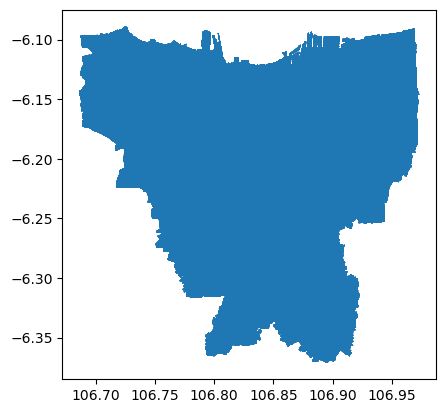

In [31]:
print(result_pop.plot())
print(result_pop.info())

In [32]:
# Dissolve berdasarkan 'KABKOT' dan 'month' dengan fungsi agregasi mean
dissolved_result = result_pop.dissolve(by=['KABKOT', 'month', 'year'])

# Reset indeks untuk membuat kolom 'KABKOT' 'month', dan 'year' menjadi kolom
dissolved_result.reset_index(inplace=True)

In [33]:
# Tampilkan hasil
dissolved_result.head()

,KABKOT,month,year,geometry,longitude,latitude,tb,time
0,JAKARTA BARAT,1,2020,"POLYGON Z ((106.71133 -6.09591 0.00000, 106.71...",106.75,-6.158333,715,2020-01-01
1,JAKARTA BARAT,1,2021,"POLYGON Z ((106.71133 -6.09591 0.00000, 106.71...",106.75,-6.158333,329,2021-01-01
2,JAKARTA BARAT,1,2022,"POLYGON Z ((106.71133 -6.09591 0.00000, 106.71...",106.75,-6.158333,851,2022-01-01
3,JAKARTA BARAT,2,2020,"POLYGON Z ((106.71133 -6.09591 0.00000, 106.71...",106.75,-6.158333,803,2020-02-01
4,JAKARTA BARAT,2,2021,"POLYGON Z ((106.71133 -6.09591 0.00000, 106.71...",106.75,-6.158333,326,2021-02-01


In [34]:
dissolved_result_df = pd.DataFrame(dissolved_result.drop(['geometry'],axis = 1))
#dissolved_result_df = dissolved_result_df.drop(['geometry'], axis=1) #kolom geometry di hapus

In [35]:
#untuk mengurutkan file berdasarkan
dissolved_result_df = dissolved_result_df.sort_values(by=[ 'year', 'KABKOT', 'month'])

In [36]:
dissolved_result_df

,KABKOT,month,year,longitude,latitude,tb,time
0,JAKARTA BARAT,1,2020,106.750000,-6.158333,715,2020-01-01
3,JAKARTA BARAT,2,2020,106.750000,-6.158333,803,2020-02-01
6,JAKARTA BARAT,3,2020,106.750000,-6.158333,689,2020-03-01
9,JAKARTA BARAT,4,2020,106.750000,-6.158333,359,2020-04-01
12,JAKARTA BARAT,5,2020,106.750000,-6.158333,276,2020-05-01
...,...,...,...,...,...,...,...
167,JAKARTA UTARA,8,2022,106.891667,-6.125000,636,2022-08-01
170,JAKARTA UTARA,9,2022,106.891667,-6.125000,712,2022-09-01
173,JAKARTA UTARA,10,2022,106.891667,-6.125000,715,2022-10-01
176,JAKARTA UTARA,11,2022,106.891667,-6.125000,685,2022-11-01


In [37]:
polygon_result = gpd.sjoin(gdf_shapefile, dissolved_result, how='inner', predicate='intersects')

In [38]:
print(polygon_result.columns)

Index(['PROVNO', 'KABKOTNO', 'PROVINSI', 'KABKOT_left', 'geometry',
       'index_right', 'KABKOT_right', 'month', 'year', 'longitude', 'latitude',
       'tb', 'time'],
      dtype='object')


In [39]:
import calendar

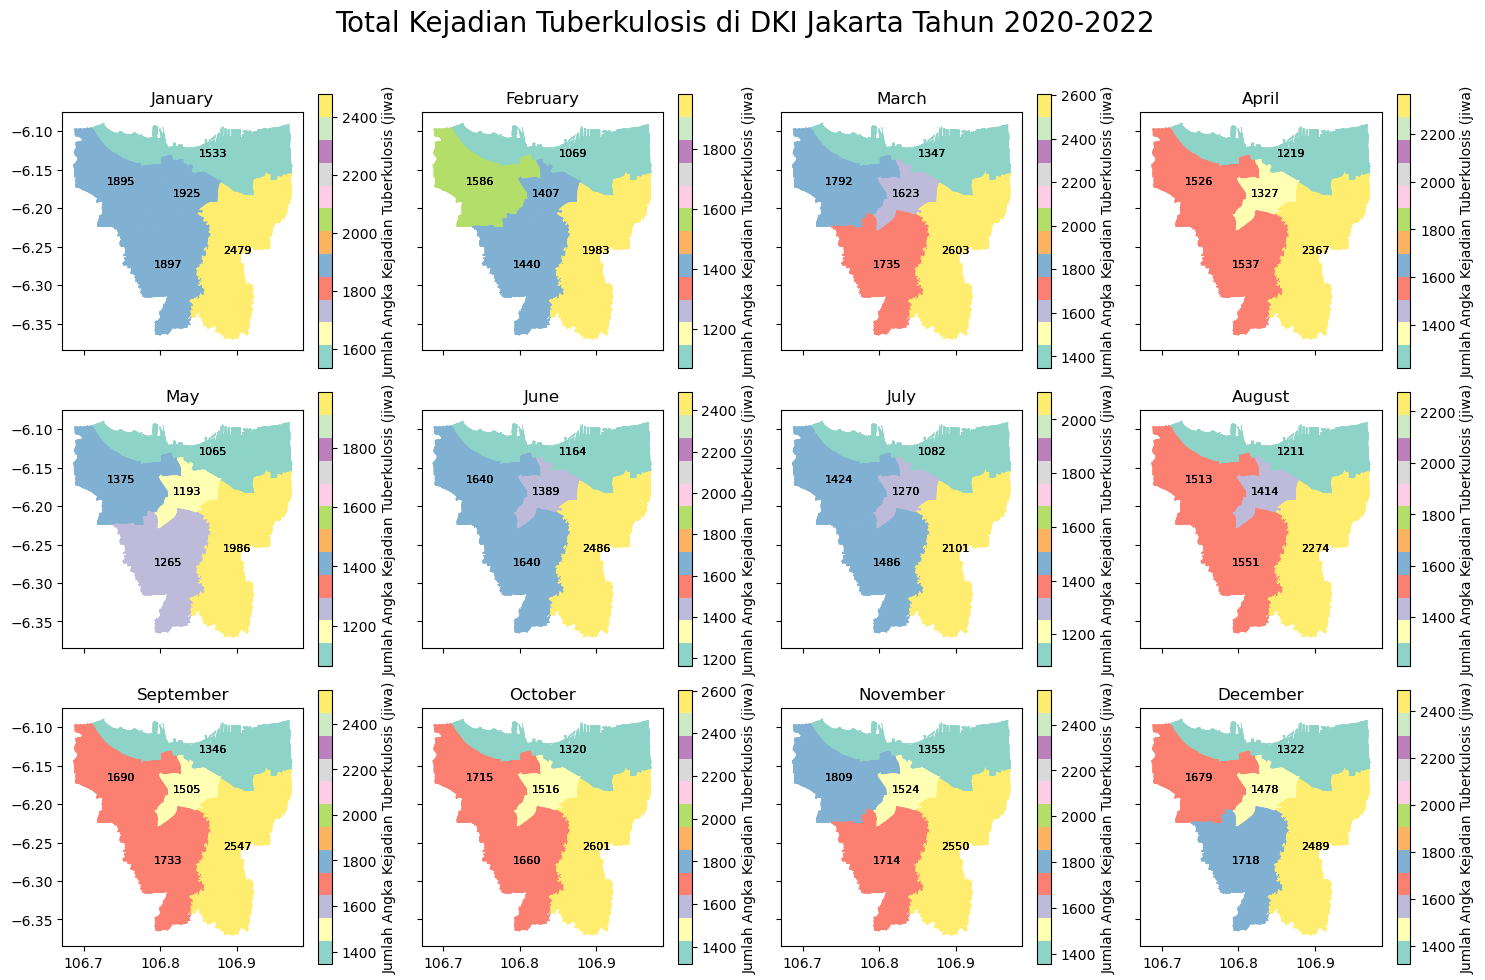

In [59]:
# Filter data for the years 2020 to 2022
data_2020_2022 = dissolved_result[(dissolved_result['year'] >= 2020) & (dissolved_result['year'] <= 2022)]

# Create a figure with subplots for each month
fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Total Kejadian Tuberkulosis di DKI Jakarta Tahun 2020-2022', fontsize=20)

# Iterate through each month and plot the data for the years 2020 to 2022
for month, ax in zip(range(1, 13), axs.flatten()):
    # Filter data for the current month and years 2020 to 2022
    data_monthly = data_2020_2022[data_2020_2022['month'] == month]

    # Calculate the total TB cases for each Kabupaten/Kota for the current month
    total_tb_per_kabkot = data_monthly.groupby(['KABKOT'])['tb'].sum().reset_index()

    # Merge the total TB cases back to the GeoDataFrame for the current month
    data_monthly_total_tb = data_monthly.merge(total_tb_per_kabkot, on='KABKOT', how='left', suffixes=('_original', '_total'))

    # Plot the map for the current month
    data_monthly_total_tb.plot(ax=ax, column="tb_total", legend=True, legend_kwds={"label": "Jumlah Angka Kejadian Tuberkulosis (jiwa)"})

    # Annotate each polygon with total TB cases value
    for idx, row in data_monthly_total_tb.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['tb_total']:.0f}", fontsize=8, ha='center', va='center')

    ax.set_title(calendar.month_name[month])  # Using calendar module to get the month name

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

cmap = plt.get_cmap('Set3')
plt.set_cmap(cmap)

# Show the plot
plt.show()

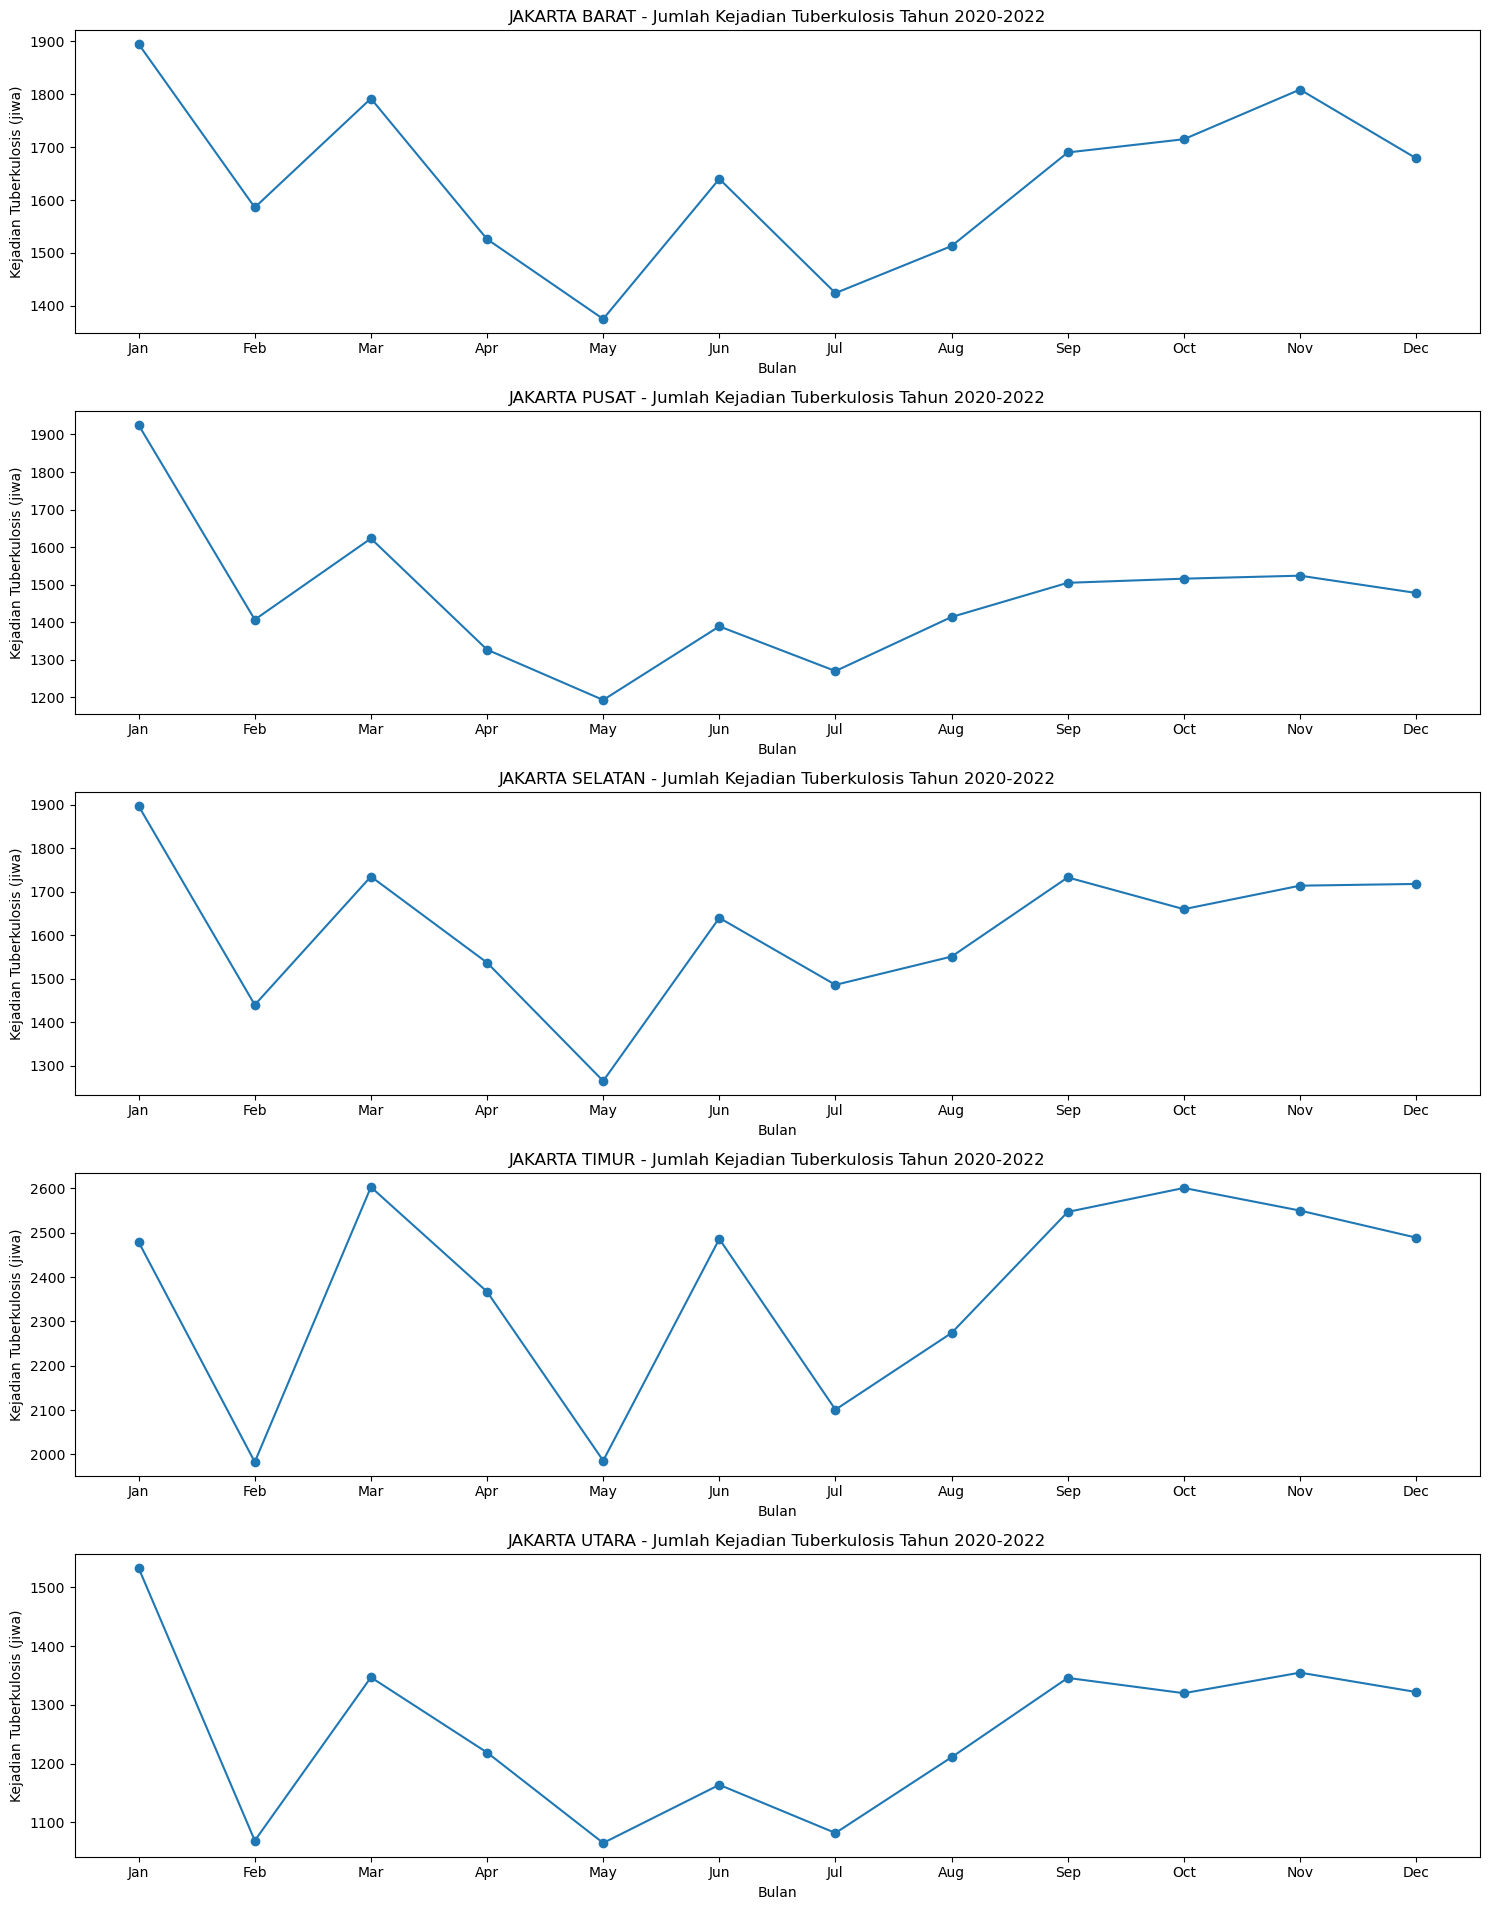

In [41]:
# Filter data for the years 2020 to 2022
data_2020_2022 = dissolved_result_df[(dissolved_result_df['year'] >= 2020) & (dissolved_result_df['year'] <= 2022)]

# Create a figure with subplots for each city
fig = plt.figure(figsize=(15, 20))
cities = list(data_2020_2022['KABKOT'].unique())

# Iterate through each city and plot the total TB cases for the years 2020 to 2022
for idx, city in enumerate(cities, start=1):
    # Filter data for the current city and years 2020 to 2022
    data_city_2020_2022 = data_2020_2022[data_2020_2022['KABKOT'] == city]

    # Calculate the monthly averages
    monthly_total = data_city_2020_2022.groupby('month')['tb'].sum()

    # Plot the map for the current city
    plt.subplot(len(cities), 1, idx)
    plt.plot(monthly_total, marker='o')
    plt.title(f'{city} - Jumlah Kejadian Tuberkulosis Tahun 2020-2022')
    plt.xlabel('Bulan')
    plt.ylabel('Kejadian Tuberkulosis (jiwa)')
    plt.xticks(range(1, 13), [calendar.month_abbr[i] for i in range(1, 13)])  # Display month names

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

In [42]:
print(dissolved_result_df.columns)

Index(['KABKOT', 'month', 'year', 'longitude', 'latitude', 'tb', 'time'], dtype='object')


In [43]:
dissolved_result_df

,KABKOT,month,year,longitude,latitude,tb,time
0,JAKARTA BARAT,1,2020,106.750000,-6.158333,715,2020-01-01
3,JAKARTA BARAT,2,2020,106.750000,-6.158333,803,2020-02-01
6,JAKARTA BARAT,3,2020,106.750000,-6.158333,689,2020-03-01
9,JAKARTA BARAT,4,2020,106.750000,-6.158333,359,2020-04-01
12,JAKARTA BARAT,5,2020,106.750000,-6.158333,276,2020-05-01
...,...,...,...,...,...,...,...
167,JAKARTA UTARA,8,2022,106.891667,-6.125000,636,2022-08-01
170,JAKARTA UTARA,9,2022,106.891667,-6.125000,712,2022-09-01
173,JAKARTA UTARA,10,2022,106.891667,-6.125000,715,2022-10-01
176,JAKARTA UTARA,11,2022,106.891667,-6.125000,685,2022-11-01


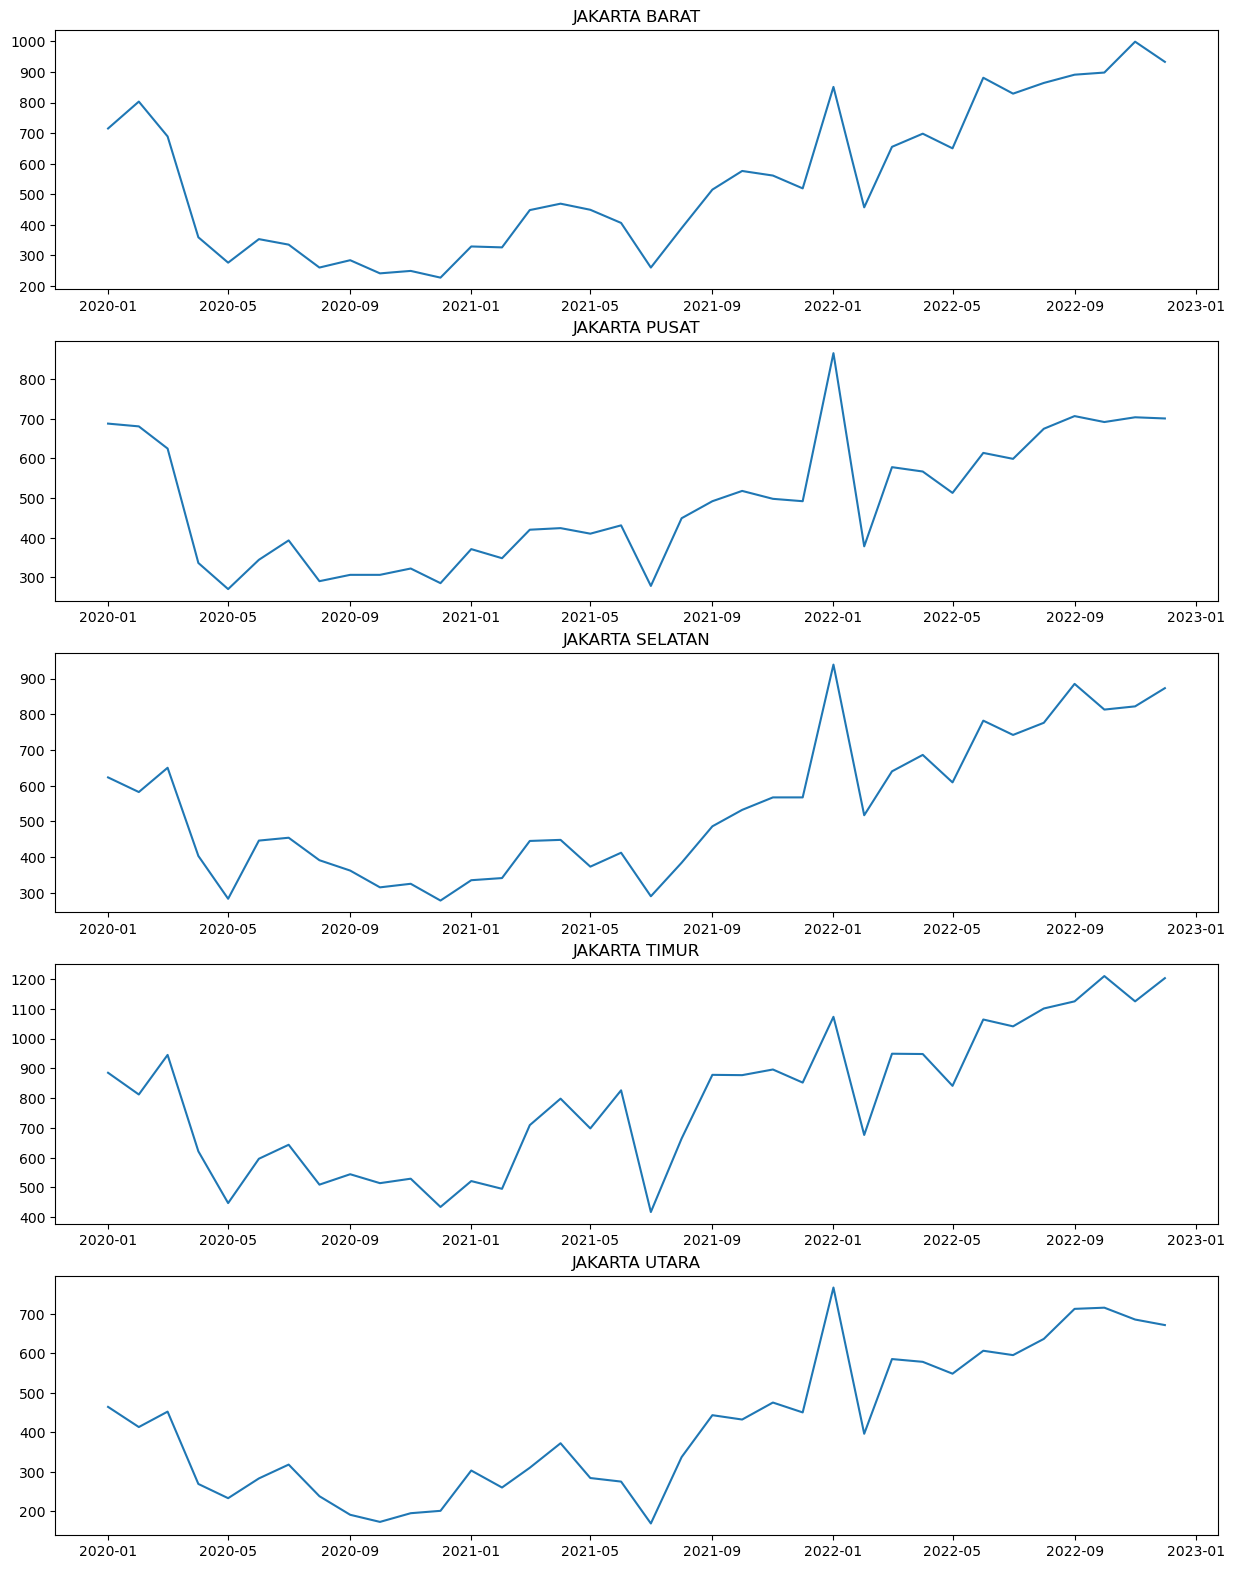

In [44]:
import calendar

fig  = plt.figure(figsize=(15,60))
cities = list(dissolved_result_df['KABKOT'].unique())
dissolved_result_df = dissolved_result_df.set_index('time')

# Iterate through each month and plot the data
for city, ax in zip(cities, range(1,6)):
    # Filter data for the current wilayah admin
    data_city = dissolved_result_df[dissolved_result_df['KABKOT'] == city]

    # Plot the map for the current kabkot
    fig.add_subplot(15, 1, ax)
    plt.plot(data_city['tb']) 
    plt.plot(marker='o')
    plt.title(city)
    #ax.set_title(f'{city}')